Code to test whether brain activity patterns cluster by moral strategy group (i.e. replicate over subjects within strategy group)

In [1]:
import warnings, os, sys, glob, matplotlib, scipy
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
matplotlib.rcParams['pdf.fonttype'] = 42 #To make text readable by Illustrator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, collapse_mask
from nltools.stats import threshold, one_sample_permutation, two_sample_permutation, correlation_permutation
from nilearn.plotting import plot_roi
base_dir = '/project/3014018.02/analysis_mri/DataSharingCollection/'

In [2]:
def plot_silhouette(distance, labels, ax=None, permutation_test=True,
                    n_permute=5000, colors=None, **kwargs):

    #Define label set
    labelSet = np.unique(np.array(labels))
    n_clusters = len(labelSet)

    #Set defaults for plot design
    if colors is None:
        colors = sns.color_palette("tab10", n_clusters)
    if 'figsize' not in kwargs.keys():
        figsize = (6,4)

    #Compute silhouette scores
    out = pd.DataFrame(columns=('Label','MeanWit','MeanBet','Sil'))
    for index in range(len(labels)):
        label = labels.iloc[index]
        sameIndices = [i for i,labelcur in enumerate(labels) if (labelcur==label) & (i!=index)]
        within = distance.iloc[index,sameIndices].values.flatten()
        otherIndices = [i for i,labelcur in enumerate(labels) if (labelcur!=label)]
        between = distance.iloc[index,otherIndices].values.flatten()
        silhouetteScore = (np.mean(between)-np.mean(within))/max(np.mean(between),np.mean(within))
        out_tmp = pd.DataFrame(columns=out.columns)
        out_tmp.at[index] = index
        out_tmp['Label'] = label
        out_tmp['MeanWit'] = np.mean(within)
        out_tmp['MeanBet'] = np.mean(between)
        out_tmp['Sil'] = silhouetteScore
        out = out.append(out_tmp)
    sample_silhouette_values = out['Sil']

    # Get axis to plot on
    if ax is None:
        f,ax = plt.subplots(1,figsize = figsize)
        returnFig = True
    else:
        returnFig = False

    # Build plot
    x_lower = 10
    labelX = []
    for labelInd in range(n_clusters):
        label = labelSet[labelInd]
        ith_cluster_silhouette_values = sample_silhouette_values[labels == label]
        ith_cluster_silhouette_values.sort_values(inplace=True)
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        x_upper = x_lower + size_cluster_i

        color = colors[labelInd]
        with sns.axes_style("white"):
            ax.fill_between(np.arange(x_lower,x_upper),0,ith_cluster_silhouette_values,
                        facecolor=color,edgecolor=color)

        labelX = np.hstack((labelX,np.mean([x_lower,x_upper])))
        x_lower = x_upper + 3

    #Format plot
    ax.set_xticks(labelX)
    ax.set_xticklabels(labelSet)
    ax.set_title('Silhouettes',fontsize=18)
    ax.set_xlim([5,10+len(labels)+n_clusters*3])

    #Permutation test on mean silhouette score per label
    if permutation_test:
        outAll = pd.DataFrame(columns=['label','mean','p'])
        for labelInd in range(n_clusters):
            temp = pd.DataFrame(columns=outAll.columns)
            label = labelSet[labelInd]
            data = sample_silhouette_values[labels == label]
            temp.loc[labelInd,'label'] = label
            temp.loc[labelInd,'mean'] = np.mean(data)
            if np.mean(data)>0: #Only test positive mean silhouette scores
                statsout = one_sample_permutation(data, tail = 1, n_permute = n_permute)
                temp['p'] = statsout['p']
            else:
                temp['p'] = 999
            outAll = outAll.append(temp)
        if returnFig:
            return (f, outAll)
        else:
            return outAll
    else:
        if returnFig:
            return f

## Load behavioral clusters

In [2]:
fittedParams = pd.read_csv(os.path.join(base_dir,
                            'Results/2.Behavior-ClusterModel/ParticipantClustering.csv')
                           ,index_col=0)
print fittedParams.head()
subNums = np.array(fittedParams['sub'].unique())
print subNums
print len(subNums)

   sub     model     theta       phi    SSE         AIC         BIC Sample  \
0  124  MP_ppSOE  0.340718  0.055082   65.0   -7.882301   -3.220835    old   
1  126  MP_ppSOE  0.078473  0.000799  205.0   79.413025   84.074491    old   
2  128  MP_ppSOE  0.030199  0.059205  255.0   96.000296  100.661762    old   
3  129  MP_ppSOE  0.206195 -0.095803  203.0   78.667921   83.329387    old   
4  130  MP_ppSOE  0.078536 -0.017041  323.0  113.965843  118.627309    old   

   clust ClustName  
0      1        GR  
1      4        MO  
2      3        IA  
3      4        MO  
4      4        MO  
[124 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 148 150 151 152 153 154 156 157 158 159 160 161 162 164 165
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 189
 190 191 192]
57


In [3]:
fittedParams['ClustName'].value_counts()

IA    24
MO    21
GR     7
GA     5
Name: ClustName, dtype: int64

## Load parcellation

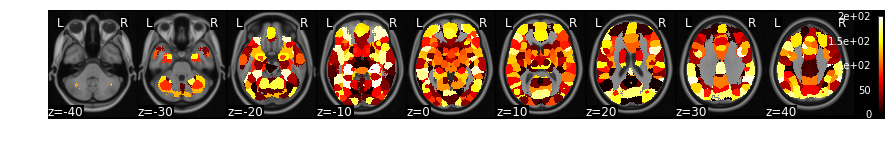

In [4]:
nparcel = 200
roi = Brain_Data(os.path.join(base_dir,'Data/6.Parcellation/whole_brain_cluster_labels_PCA=100_k=%s.nii.gz' % nparcel))
roi.plot()
roi_x = expand_mask(roi)

## Load IS-RSA results

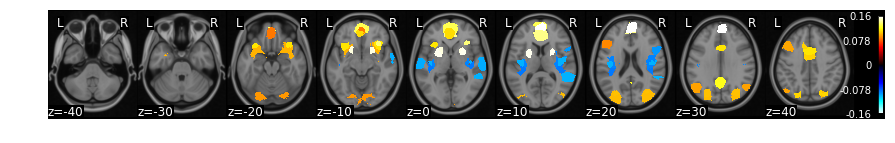

In [5]:
permutation_method = 'vector'
screen = 'Mult'
cond = 'X4'
thresh = 0.05
thresh_type = 'bonf'
ISRSA = Brain_Data(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps',
         'Maps_nparcel-%i_perm-%s/%s%s_R-thr-%.2f-%s.nii.gz' % (
            nparcel,permutation_method,screen,cond,thresh,thresh_type)))
ISRSA.plot();

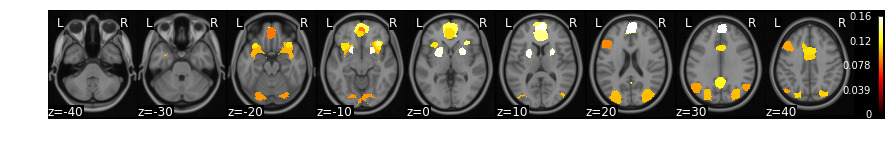

In [6]:
# Select only parcels with significant positive association
ISRSA_positive = ISRSA.copy()
ISRSA_positive.data[ISRSA_positive.data<0] = 0
ISRSA_positive.plot();

In [7]:
parcels = np.unique(roi.data[ISRSA_positive.data>0])-1 # The data in roi are 1-indexed since 0 represents air
print parcels
print len(parcels)

[ 14  25  54  58  63  79  87  95  96 104 109 128 132 135 136 140 141 143
 145 146 147 155 158 159 173 183 191]
27


## Compute silhouette scores per cluster and parcel in x4 condition

[ 14  25  54  58  63  79  87  95 104 109 128 132 135 136 140 141 143 145
 146 147 155 158 159 173 183 191]
Excluded groups: ['GR']


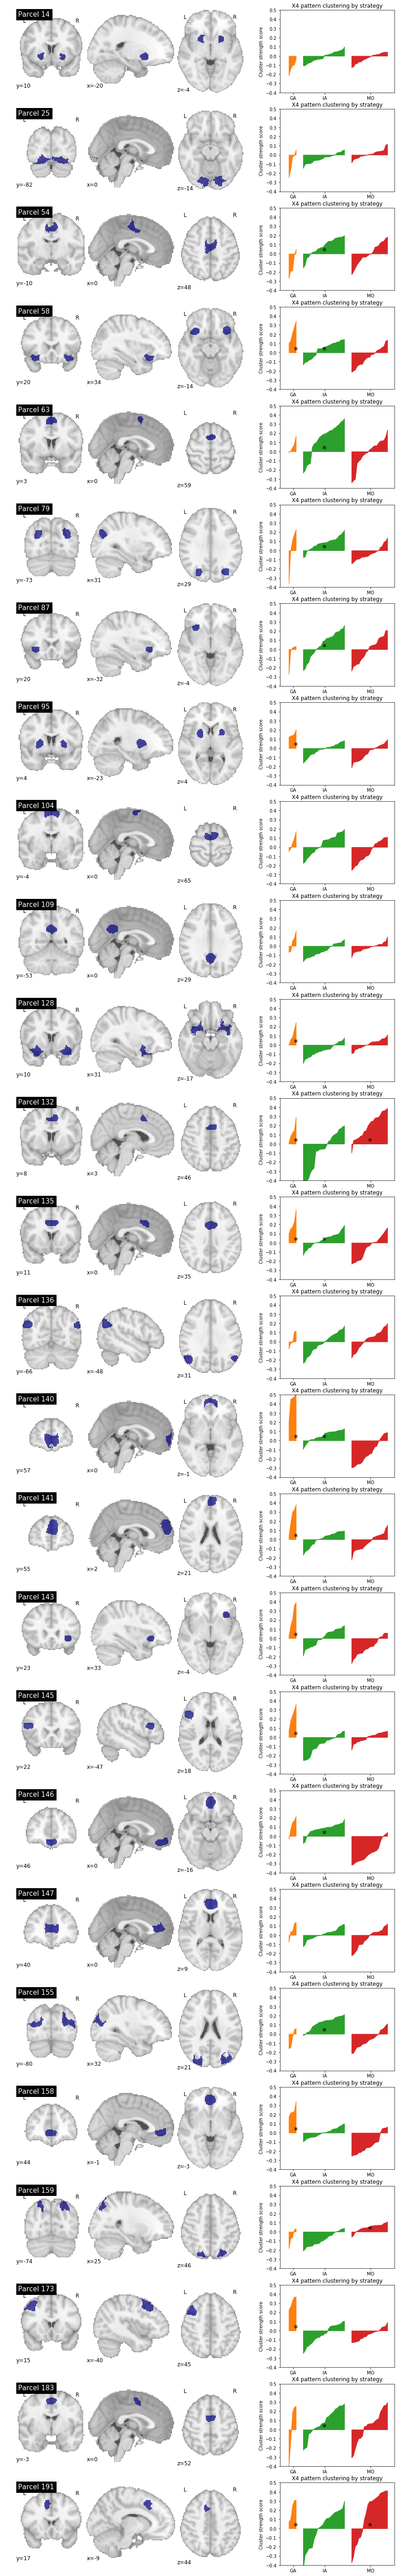

In [10]:
# Settings
screen = 'Mult'
metric_brain = 'correlation'
parcelSel = parcels
print parcelSel
groupExcludes = [['GR']] #Must be list of lists, which allows exclusion of multiple groups at once if you want
cond = 'X4'

for groupExclude in groupExcludes:
    print 'Excluded groups: %s'%groupExclude
    if groupExclude[0] == 'GR':
        colorOrder = [sns.color_palette('tab10',4)[i] for i in [1,2,3]] # To match colors in parameter space plot
    elif groupExclude[0] == 'none':
        colorOrder = [sns.color_palette('tab10',4)[i] for i in [1,0,2,3]]
        
    # Process
    labels = np.array(fittedParams['ClustName'])
    subIndices = np.where(~fittedParams['ClustName'].isin(groupExclude))[0] #Also works with 'none'
    labels = pd.Series(labels[subIndices])
    groupSizes = np.array(np.sort(labels.value_counts()))

    # Set up results
    stats_all = pd.DataFrame()
    fig,ax = plt.subplots(len(parcelSel),2,
                          figsize=[15,len(parcelSel)*4],
                          gridspec_kw={'width_ratios':[2,1]})
    # Draw parcel plots
    for parcelInd, parcel in enumerate(parcelSel):
        plot_roi(os.path.join(base_dir,'Data/6.Parcellation/ParcelNiftis_%i/parcel_%i.nii.gz'%(nparcel,parcel)),
                 title='Parcel %i'%parcel,axes=ax[parcelInd,0],draw_cross=False)
    
    # Load brain distance matrix
    brainDist = pd.read_csv(os.path.join(base_dir,'Results/3.fMRI-ISRSA/BrainDist',
                         'BrainDist_%s_%s%s_roi%s.csv' % (metric_brain, screen,cond, nparcel)))
    for parcelInd, parcel in enumerate(parcelSel):
        brainDist_ROI = brainDist.iloc[:,parcel]
        brainDist_ROI = pd.DataFrame(scipy.spatial.distance.squareform(brainDist_ROI))
        brainDist_ROI = brainDist_ROI.iloc[subIndices,subIndices]
        stats = plot_silhouette(brainDist_ROI,labels,ax=ax[parcelInd,1],colors=colorOrder)
        ax[parcelInd,1].set_title('%s pattern clustering by strategy'%(cond))
        ax[parcelInd,1].set_ylabel('Cluster strength score')
        ax[parcelInd,1].set_ylim([-.4,.5])
        stats['cond'] = cond
        stats['parcel'] = parcel
        stats_all = stats_all.append(stats)
        if sum(stats.p<0.05) > 0:
            sigGroups = np.where(stats.p<0.05)[0]
            for i in sigGroups:
                xloc = 10 + sum(groupSizes[0:i]) + 3*i + .5*groupSizes[i]
                ax[parcelInd,1].text(xloc,0,'*',fontsize=20,color='k')
#     plt.tight_layout()
    fig.savefig(os.path.join(base_dir,'Results/4.fMRI-PatternClustering',
        'Silhouettes_X4_exclude-%s.png'%('-'.join(groupExclude))),
        format='png',dpi=200, bbox_inches='tight')
    stats_all.to_csv(os.path.join(base_dir,'Results/4.fMRI-PatternClustering',
        'SilhouetteScores_X4_exclude-%s.csv'%('-'.join(groupExclude))))

## Plot brain map of 'active' parcels per moral strategy group

GA [ 58  95 128 132 135 140 141 143 145 158 173 191] [0.21505063 0.15129331 0.11438758 0.13327418 0.20560653 0.4289748
 0.24692691 0.22651488 0.23052283 0.24082793 0.31218121 0.20867349]


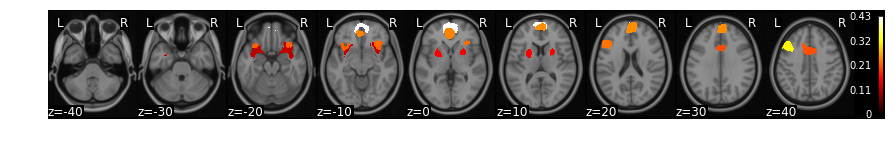

IA [ 54  58  63  79  87 135 140 146 155 183] [0.07745584 0.03535024 0.13403293 0.08052521 0.05497822 0.03354946
 0.05359238 0.08039637 0.1232829  0.08115457]


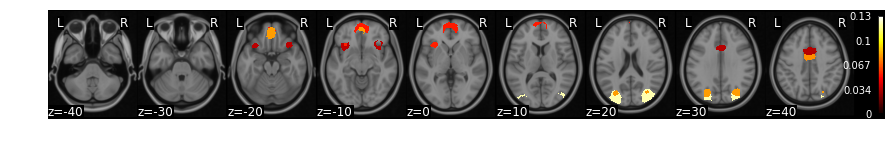

MO [132 159 191] [0.19789413 0.04744805 0.15180341]


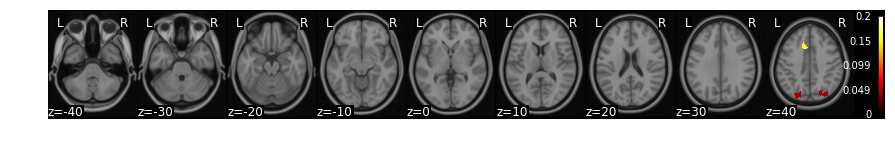

In [8]:
groupExclude = ['GR']
stats_all = pd.read_csv(os.path.join(base_dir,'Results/4.fMRI-PatternClustering',
    'SilhouetteScores_X4_exclude-%s.csv'%('-'.join(groupExclude))),index_col=0)
x4sig = stats_all.loc[(stats_all['cond']=='X4') & (stats_all['p'] < 0.05)
                     ].reset_index(drop=True)
x4sig

for clust in ['GA','IA','MO']:
#     parcels = x4sig.loc[x4sig['label']==clust,'parcel']
    active = x4sig.loc[(x4sig['label']==clust)].index
    parcels = np.array(x4sig.loc[active,'parcel'])
    means = np.array(x4sig.loc[active,'mean'])
    print clust, parcels, means
    active_map = collapse_mask(roi_x[parcels],auto_label=True)
    active_map_means = roi.copy()
    active_map_means.data[:] = float(0)
    for i,parcel in enumerate(parcels):
        active_map_means.data[roi_x[parcel].data>0] = means[i]*100000
    active_map_means.data = active_map_means.data.astype(float)/100000
    active_map_means.plot()

    plt.savefig(os.path.join(base_dir,
         'Results/4.fMRI-PatternClustering/PatternClustering_X4_%s_meanDiffs.png' % (
            clust)))
    plt.show()
    active_map_means.write(os.path.join(base_dir,
         'Results/4.fMRI-PatternClustering/PatternClustering_X4_%s_meanDiffs.nii.gz' % (
            clust)))

/home/decision/jervbaa/.conda/envs/hmtg_fmri_nc/lib/python2.7/site-packages/nilearn/plotting/find_cuts.py:285: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3


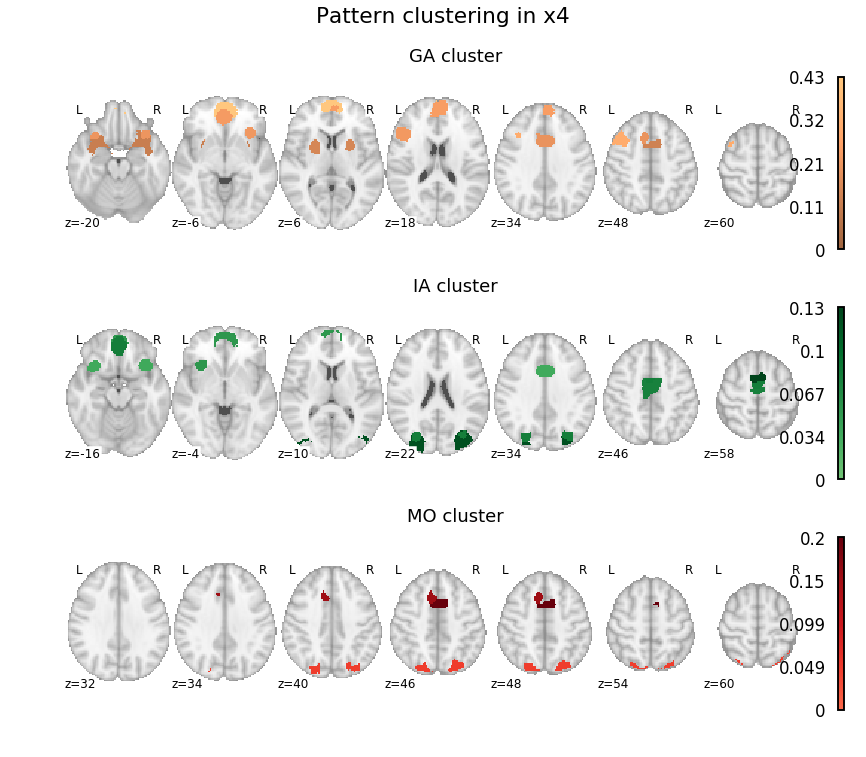

In [12]:
from nilearn.plotting import plot_stat_map

sns.set_context('talk')
fig,ax = plt.subplots(3,1,figsize=[14,12])
colormaps = ['copper','Greens','Reds']
for i,clust in enumerate(['GA','IA','MO']):
    img = os.path.join(base_dir,'Results/4.ClusterBrain',
           'PatternClustering_X4_%s_meanDiffs.nii.gz'%(
               clust))
    plot_stat_map(img,axes=ax[i],draw_cross=False,display_mode='z',
                  cut_coords=7,cmap=colormaps[i])
    ax[i].set_title('%s cluster'%clust)
plt.suptitle('Pattern clustering in x4',y=0.95)
plt.savefig(os.path.join(base_dir,
 'Results/4.fMRI-PatternClustering/PatternClustering_X4_all_meanDiffs.png'),dpi=200)

## Plot brain space for one parcel/condition to illustrate clustering

In [13]:
parcelSel

array([ 14,  25,  54,  58,  63,  79,  87,  95, 104, 109, 128, 132, 135,
       136, 140, 141, 143, 145, 146, 147, 155, 158, 159, 173, 183, 191])

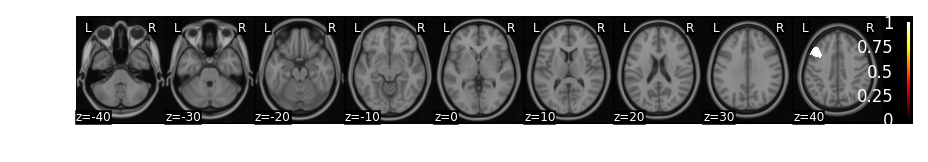

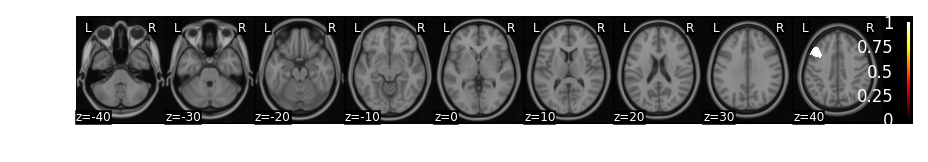

In [14]:
parcelSel = 173
roi_x[parcelSel].plot()

In [15]:
subNums

array([124, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 148, 150, 151, 152, 153,
       154, 156, 157, 158, 159, 160, 161, 162, 164, 165, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 189, 190, 191, 192])

In [ ]:
screen = 'Mult'
dat_x4 = Brain_Data()
for sub in subNums:
    dat_x4 = dat_x4.append(Brain_Data(glob.glob(os.path.join(base_dir,
                    'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X4')))).mean())

In [27]:
dat_x4_zscore = dat_x4.copy()
parcelLocs = []
for parcel in range(200):
    print parcel,
    parcelLocs.append(np.where(roi_x[parcel].data==1))
print ''
for subInd,sub in enumerate(subNums):
    print sub,
    subMap = dat_x4_zscore[subInd].copy()
    subDat = subMap.data
    for parcel in range(200):
        parcelLoc = parcelLocs[parcel][0]
        subDat[parcelLoc] = ss.zscore(subDat[parcelLoc])
    subMap.data = subDat
    dat_x4_zscore[subInd] = subMap

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
124 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 148 150 151 152 153 154 156 157 158 159 160 161 162 164 165 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 189 190 191 192


In [ ]:
import hypertools

In [29]:
subInds = np.where(fittedParams['ClustName'].isin(['GA','IA','MO']))[0]
dat_select = dat_x4_zscore[subInds].apply_mask(roi_x[parcelSel])

In [30]:
subInds

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 48, 50, 51, 52, 53, 54, 55, 56])

In [31]:
dat_select

nltools.data.brain_data.Brain_Data(data=(50, 745), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

In [32]:
labels = np.array(fittedParams.loc[subInds,'ClustName'])
print labels

['MO' 'IA' 'MO' 'MO' 'MO' 'IA' 'IA' 'MO' 'MO' 'MO' 'IA' 'MO' 'IA' 'IA'
 'GA' 'IA' 'IA' 'IA' 'GA' 'IA' 'IA' 'IA' 'IA' 'GA' 'MO' 'IA' 'GA' 'MO'
 'MO' 'MO' 'IA' 'MO' 'IA' 'MO' 'MO' 'IA' 'MO' 'MO' 'IA' 'IA' 'MO' 'IA'
 'IA' 'MO' 'GA' 'MO' 'MO' 'IA' 'IA' 'IA']


GA IA MO

/home/decision/jervbaa/.conda/envs/hmtg_fmri_neuron/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


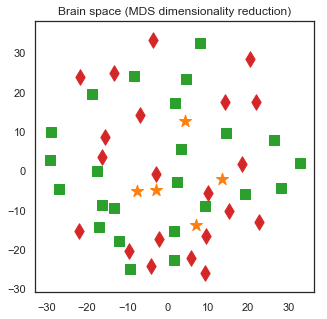

In [36]:
colors = sns.color_palette('tab10',4)
markers = ['o','*','s','d']
sizes = np.multiply([50,80,50,60],2)
groupOrder = ['GR','GA','IA','MO']
reductionMethod = 'MDS'
reduced_data = hypertools.tools.reduce(dat_select.data,ndims=2,reduce=reductionMethod)
sns.set_style('white')
fig,ax = plt.subplots(1,1,figsize=[5,5])
for clust in np.unique(labels):
    print clust,
    clustInd = groupOrder.index(clust)
    ax.scatter(reduced_data[labels==clust,0],reduced_data[labels==clust,1],
               c=colors[clustInd],marker=markers[clustInd],s=sizes[clustInd])
ax.set_title('Brain space (%s dimensionality reduction)'%reductionMethod)
fig.show()
plt.savefig(os.path.join(base_dir,'Results/4.fMRI-PatternClustering/Brain-space_reduce-%s_parcel-%i_%s%s.eps'%(
            reductionMethod,parcelSel,screen,'X4')),dpi=200,bbox_inches='tight')
plt.savefig(os.path.join(base_dir,'Results/4.fMRI-PatternClustering/Brain-space_reduce-%s_parcel-%i_%s%s.png'%(
            reductionMethod,parcelSel,screen,'X4')),dpi=200,bbox_inches='tight')